In [1]:
# Kenneth Meyer
# 4/18/23
# multiresolution DMD using the pydmd library

In [2]:
# goal: preform mrDMD, in 2D (to create a movie), with squares, noise, other signals, and jeff.

In [3]:
import matplotlib.pyplot as plt
from pydmd import MrDMD, DMD
from pydmd.plotter import plot_eigs_mrdmd
import numpy as np
from PIL import Image
import matplotlib.animation as animation
from pydmd.plotter import plot_modes_2D

In [4]:
## filepaths for images and for output
outpath = '../figs/square_circle_output/'
jeff_image_path = '../figs/jeff/'

jeff1 = "robojeff.png"
jeff2 = "dilated_jeff.jpg"

In [5]:
## import, and visualize, the image of jeff to check it's working.
jeff_img = Image.open(jeff_image_path + jeff2)
jeff_img_pix = np.asarray(jeff_img)
print("shape of image of jeff")
print(jeff_img_pix.shape)
#print(jeff_img_pix[0])

### note: might need to make this image a greyscale image so dmd can be ran on it.....

shape of image of jeff
(128, 128, 3)


In [6]:
## construct a sample grid to perform dmd on!
## note: trying to do mrDMD with varying types of svd approaches could have been cool...might have run out of time.
nx = 256
ny = 256
n = nx*ny

x_arr = np.arange(0,256)
y_arr = np.arange(0,256)

# 100 total timesteps right now.
T = 10
dt = 0.01
t = np.arange(dt,T+dt,dt)

# perform all operations as 2D arrays (position x time) and then ravel/reshape them
## ^IGNORE this for now.
#D = np.zeros((nx,ny,len(t)))

# way faster - use meshgrid
#Xm,Ym,Tm = np.meshgrid(x_arr,y_arr,t)
Xm,Ym = np.meshgrid(x_arr,y_arr) # useful for a couple signals, I think

In [ ]:
# Define the 3D matrix Xclean
Xclean = np.ones((ny,nx))
    
x, y = np.meshgrid(np.arange(nx), np.arange(ny))
for i in range(len(t)):
    Xclean[i, :, :] -= 0.5 + 0.5 * np.cos(2 * np.pi * t[i] * 10)*(np.sqrt((x-nx/2)**2 + (y-ny/2)**2) < 25)  #10Hz

    # Xclean[i, :, :] -= 0.5 + 0.5 * np.cos(t[i] * 10) * (np.sqrt((x-nx/2)**2 + (y-ny/2)**2) < 25) #5Hz


# Add the square blinking pattern
for i in range(len(t)):
    Xclean[i, 20:40, 20:40] -= 0.5 + 0.5 * np.cos(2 * np.pi * t[i] * 10) #10Hz
    # Xclean[i, 20:40, 20:40] -= 0.5 + 0.5 * np.cos(t[i] * 100) #10Hz

In [7]:
## define some signals


jeff_im_size_x = int(jeff_img_pix.shape[0]/2)
jeff_im_size_y = int(jeff_img_pix.shape[1]/2)
## generates proper array of data to populate to form a circle


# centers of each of the signals
center_1 = [20,20]
center_2 = [58,400]
center_3 = [200,200]
center_4 = [100,100]
center_5 = [128,128]

# dimensions of squares being used
s1 = 15
s3 = 20

# dimensions of circles being used
r1 = 25
r2 = 15

# square with rbg value of 10
D1 = np.zeros((nx,ny,3))
D1[center_1[0]-s1:center_1[0]+s1,center_1[1]-s1:center_1[1]+s1] = [100,25,4]

## adding modes to replicate the example they have in the book!!
## NOTE: this code is half-complete to handle this/does not handle this at all. Going to rerun DMD with the jeff example with more timesteps
##once to get better video.
# the d2 signal needs to be improved a bit here.
#D2 = np.exp(-1*((Xm-40)**2/250+(Ym-40)**2/250))
D2 = 0.5 + 0.5 * np.cos(2 * np.pi * t[i] * 100)*(np.sqrt((x-nx/2)2 + (y-ny/2)2) < 25)
D4 = np.zeros((nx,ny))
D4[nx-40:nx-10,ny-40:ny-10] = 1
D6 = np.zeros((nx, ny)) 
D6[1:nx-20, 1:ny-20] = 1



# circle with rbg value of 140
#D1 = np.zeros((nx,ny))
#D_i[center_1[0]-s1:center_1[0]+s1,center_1[1]-s1:center_1[1]+s1] = 10

# square with rbg value of 140
D3 = np.zeros((nx,ny,3))
D3[center_3[0]-s3:center_3[0]+s3,center_3[1]-s3:center_3[1]+s3] = [0,0,140]

# populating signal with JEFF
D5 = np.zeros((nx,ny,3))
D5[center_5[0] - jeff_im_size_x:center_5[0] + jeff_im_size_x,center_5[1] - jeff_im_size_y:center_5[1] + jeff_im_size_y] = jeff_img_pix
range_jeff = [3,7]

D7 = np.random.normal(scale=30,loc=80,size=(256,256,3))

## todo - add noise to jeff, add noise to entire plot, etc.


In [8]:
## make the signals CHANGE THROUGH TIME

## try to make this transient, i.e. have some modes have ranges that don't appear until halfway through. wait to do this though
## ^ NEED to do this, otherwise mrDMD is not even necessary...make jeff hidden until halfway through!!!

data_clean = np.zeros((nx,ny,len(t),3)) # 3 is bc we are using rbg colors.

for i in range(0,len(t)):
    snap = np.zeros((nx,ny,3))
    
    # might want amplitude to be 1 for all of them to keep them in rgb color ranges
    
    # modes for the example with only circle and square
    #snap = snap + 1*D2*np.exp(1j*1*2*np.pi*dt)**i
    
    snap = snap + D1*1*np.exp(1j*1*2*np.pi*dt)**i
    snap = snap + D3*1*np.exp(1j*30*2*np.pi*dt)**i
    # don't vary the noise and the jeff image in time.
    if t[i] > range_jeff[0] and t[i] < range_jeff[1]:
        snap = snap + D5*1*np.exp(1j*0.5*2*np.pi*dt)
    snap = snap + D7*1*np.exp(1j*0.1*2*np.pi*dt)
    data_clean[:,:,i] = snap
    
## really concerned that the mrDMD method can only take flattened data; is flattening easy/the answer? need to test this asap

/tmp/ipykernel_2703772/2575146253.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  data_clean[:,:,i] = snap


In [9]:
## function that makes a movie of the image, from the populated 3D np array, with the functions we have previously used!
def make_movie(Xclean):
    #Works
    fig, ax = plt.subplots()
    # fig.set_figheight(10000)
    # fig.set_figwidth(25)
    # fig = plt.figure()
    # ax = plt.axes(xlim=(0,7.5),ylim=(-0.5,0.5))

    #im = ax.imshow(np.real(Xclean[0]),aspect='equal',cmap='viridis')
    im = ax.imshow(np.real(Xclean[:,:,0,:]).astype(np.uint8),aspect='equal')
    #fig.colorbar(im)

    #ax.set_xticks( np.linspace(0,Xclean[0].shape[1],6,dtype=int) ,np.linspace(0,100,6) )
    #ax.set_yticks( np.linspace(Xclean[0].shape[0],0,6,dtype=int) ,np.linspace(0,100,6) )

    ax.set_title('MultiResolution DMD')

    # # Define the update function for the animation
    def update(frame):
        im.set_data(np.real(Xclean[:,:,frame,:].astype(np.uint8)))
        return [im]
        
    # # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=Xclean.shape[2], interval=200, blit=True)
    #animation.F
    #fig.patch.set_facecolor('white')
    writervideo = animation.FFMpegWriter(fps=60)
    ani.save(outpath + 'jefffff_exponentialTime_smaller.mp4', writer=writervideo)
    plt.close()

    # # Display the animation
    plt.show() 

In [10]:
## try making the movie, fingers, crossed, and then try to run mrDMD immediately after this.
make_movie(data_clean)

In [11]:
## define some signals!

## update - this code is trash lol
def square(Xm,Ym,Tm,center,s,strength,freq):
    """
        Input: 
        X_shape (tuple describing shape of image)
        t_i (scalar, specific time)
    
        Generates a square with specified center in the plot!
    """
    x_i = int(center[0])
    y_i = int(center[1])
    
    s = int(s/2)
    
    D_i = np.zeros(X_shape) # X_shape is a tuple
    D_i[x_i-s:x_i+s,y_i-s:y_i+s] = strength*np.exp(1j*freq*t_i)
    return D_i

def circle(X_shape,t_i,center,r,strength,freq):
    
    x_i = int(center[0])
    y_i = int(center[1])
    
    r = int(r)
    r_2 = r**2
    
    D_i = np.zeros(X_shape)
    for i in range(0,X_shape[0]):
        for j in range(0,X_shape[1]):
            if (x_i - i)**2 + (y_i - j)**2 < r_2:
                D_i[i,j] = 1
                
    D_i = D_i*strength*np.exp(1j*freq*t_i)
    return D_i
    

In [12]:
## add some signals to the sample!

#D_shape = (nx,ny)

#for i in range(0,len(t)):
#    D[:,:,i] = square(D_shape,t[i],(200,200),40,2,5)
#    D[:,:,i] = circle(D_shape,t[i],(100,100),20,9,0.5)
#    D[:,:,i] = square(D_shape,t[i],(300,300),30,5,2.5)
    

## perform mrDMD, reconstruct the image, and then make another movie.
note: show how the recosntruction depends on the number of levels used in DMD/recosntruction.

In [13]:
## do this ^

## note: trying mrDMD in each color is a cool idea, try this, if it doesn't work, revert to greyscale images.

D_R = data_clean[:,:,:,0]
D_G = data_clean[:,:,:,1]
D_B = data_clean[:,:,:,2]

In [14]:
## function that makes a movie of the image, from the populated 3D np array, with the functions we have previously used!
def make_movie_reconstructed(dmd,color):
    #Works
    fig, ax = plt.subplots()
    # fig.set_figheight(10000)
    # fig.set_figwidth(25)
    # fig = plt.figure()
    # ax = plt.axes(xlim=(0,7.5),ylim=(-0.5,0.5))

    #im = ax.imshow(np.real(Xclean[0]),aspect='equal',cmap='viridis')
    #im = ax.imshow(np.real(Xclean[:,:,0,:]).astype(np.uint8),aspect='equal')
    #fig.colorbar(im)

    #ax.set_xticks( np.linspace(0,Xclean[0].shape[1],6,dtype=int) ,np.linspace(0,100,6) )
    #ax.set_yticks( np.linspace(Xclean[0].shape[0],0,6,dtype=int) ,np.linspace(0,100,6) )

    ax.set_title('MultiResolution DMD')
    
    dmd_states = [state.reshape((256,256)) for state in dmd.reconstructed_data.T]

    frames = [
        [plt.imshow(state.real.astype(np.uint8))]
        for state in dmd_states
    ]

    ani = animation.ArtistAnimation(
        fig, frames, interval=200, blit=False, repeat=False
    )

    #animation.F
    #fig.patch.set_facecolor('white')
    writervideo = animation.FFMpegWriter(fps=60)
    ani.save(outpath + 'jeff_reconstructed' + color + '.mp4', writer=writervideo)
    #plt.close()

    # # Display the animation
    plt.show() 

In [15]:
%%capture
## perform DMD on each of the colors - RED
sub_dmd = DMD(svd_rank=7)
dmdR = MrDMD(sub_dmd, max_level=9, max_cycles=1)

dmdR.fit(X=D_R)
#plot_modes_2d(dmd)
make_movie_reconstructed(dmdR,'red')
#make_plot(dmd.reconstructed_data.T, x=x, y=t)

In [16]:
#plot_modes_2D(dmd)
#make_movie_reconstructed(dmd)

In [17]:
%%capture
## perform DMD on each of the colors - GREEN
sub_dmd = DMD(svd_rank=7)
dmdG = MrDMD(sub_dmd, max_level=9, max_cycles=1)

dmdG.fit(X=D_G)
make_movie_reconstructed(dmdG,'green')
#make_plot(dmd.reconstructed_data.T, x=x, y=t)

In [18]:
%%capture
## perform DMD on each of the colors - BLUE
sub_dmd = DMD(svd_rank=7)
dmdB = MrDMD(sub_dmd, max_level=9, max_cycles=1)

dmdB.fit(X=D_B)
make_movie_reconstructed(dmdB,'blue')
#make_plot(dmd.reconstructed_data.T, x=x, y=t)

In [19]:
# try to combine all of the colors into one plot
def make_movie_reconstructed(dmdR,dmdG,dmdB,color):
    #Works
    fig, ax = plt.subplots()
    # fig.set_figheight(10000)
    # fig.set_figwidth(25)
    # fig = plt.figure()
    # ax = plt.axes(xlim=(0,7.5),ylim=(-0.5,0.5))

    #im = ax.imshow(np.real(Xclean[0]),aspect='equal',cmap='viridis')
    #im = ax.imshow(np.real(Xclean[:,:,0,:]).astype(np.uint8),aspect='equal')
    #fig.colorbar(im)

    #ax.set_xticks( np.linspace(0,Xclean[0].shape[1],6,dtype=int) ,np.linspace(0,100,6) )
    #ax.set_yticks( np.linspace(Xclean[0].shape[0],0,6,dtype=int) ,np.linspace(0,100,6) )

    dmds = [dmdR,dmdG,dmdB]
    
    ax.set_title('MultiResolution DMD - Full')
    
    # combine all the colors!
    dmd_states = np.zeros((1000,256,256,3))
    i = 0
    # there was a .T
    for dmd in dmds:
        
        dmd_state = [state.reshape((256,256)) for state in dmd.reconstructed_data.T]
        dmd_states[:,:,:,i] = dmd_state
        i += 1

    # should be rgb frames now.
    frames = [
        [plt.imshow(state.real.astype(np.uint8))]
        for state in dmd_states
    ]

    ani = animation.ArtistAnimation(
        fig, frames, interval=200, blit=False, repeat=False
    )

    #animation.F
    #fig.patch.set_facecolor('white')
    writervideo = animation.FFMpegWriter(fps=60)
    ani.save(outpath + 'jeff_reconstructed_rgb_' + color + '.mp4', writer=writervideo)
    #plt.close()

    # # Display the animation
    plt.show() 


/tmp/ipykernel_2703772/3093642390.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  dmd_states[:,:,:,i] = dmd_state


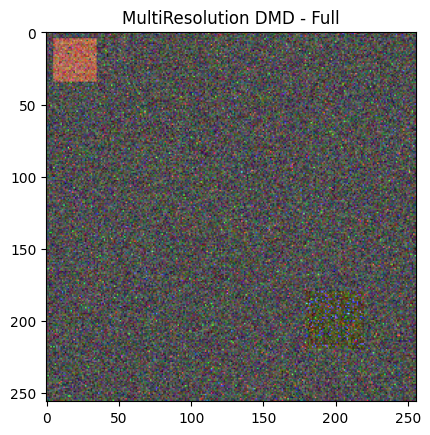

In [20]:
make_movie_reconstructed(dmdR,dmdG,dmdB,'yellllooww')

## look at specific levels, see what each of them capture, try to extract specifc modes
i.e., loop through each level and make a movie/plot the results to see what's happening

In [21]:
### checking to see if DMD alone can work on this. answer could be yes because events might not be transient.
dmd_normal_R = DMD(svd_rank=4)
dmd_normal_R.fit(X=data_clean[:,:,:,0])

dmd_normal_G = DMD(svd_rank=4)
dmd_normal_G.fit(X=data_clean[:,:,:,1])

dmd_normal_B = DMD(svd_rank=4)
dmd_normal_B.fit(X=data_clean[:,:,:,2])

/home/kenneth/virtual_environments/cse382m/lib/python3.10/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 3.6004895656862407e+34. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/kenneth/virtual_environments/cse382m/lib/python3.10/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 2.8943576205302368e+35. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/home/kenneth/virtual_environments/cse382m/lib/python3.10/site-packages/pydmd/snapshots.py:72: UserWarning: Input data condition number 6.300164160297338e+19. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


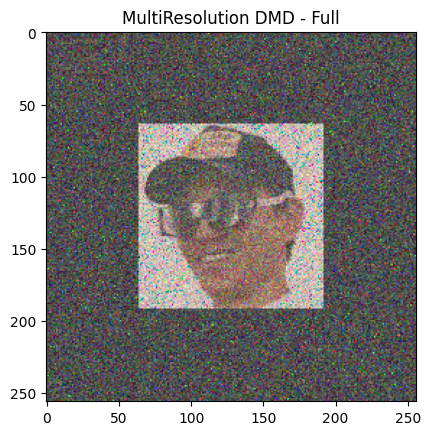

In [22]:
## plot the reconstruction all together
make_movie_reconstructed(dmd_normal_R,dmd_normal_G,dmd_normal_B,'normal_dmd')